# Detecting Retina Damage From Optical Coherence Tomography (OCT) Images, using Transfer Learning on VGG16 CNN Model

In [600]:
#!pip install keract

## Imports

In [601]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [602]:
# creation des dossiers du model
model_name = 'vgg16_e10b64_6'
# creation du dossier du modèle
if not os.path.exists(model_name):
   os.makedirs(model_name)
if not os.path.exists(model_name+'/img'):
   os.makedirs(model_name+'/img')

In [603]:
# définition des hyperparamètres du model
numepochs = 10
batch_size = 64

## Dataset

In [604]:
data_dir = "../data/OCT2017/"
train_data_dir= '../data/OCT2017/train/'
val_data_dir= '../data/OCT2017/val/'
test_data_dir= '../data/OCT2017/test/'

In [605]:
img_width, img_height = 150, 150 
channels = 3

In [606]:
# returns a dataframe from dataset path
def create_dataframe(path) : 

   categories = os.listdir(path)
   print(f"Types of classes found: {len(categories)}")

   files = []

   # Get all the file names
   for cat in categories:
      all_data = os.listdir(path+cat)
      
      # Add them to the list
      for data in all_data:
         files.append((cat, str(path +cat) + '/' + data))

   df = pd.DataFrame(data=files, columns=['classe', 'image'])

   # Let's check how many samples for each category are present
   print(f"Total number of retinas in the train dataset: {len(df)}")
   print(f"retinas in each category:\n {df['classe'].value_counts()}")
   
   return df

In [607]:
# Build a train dataframe        
train_df = create_dataframe(train_data_dir)

Types of classes found: 4
Total number of retinas in the train dataset: 83484
retinas in each category:
 CNV       37205
NORMAL    26315
DME       11348
DRUSEN     8616
Name: classe, dtype: int64


In [608]:
# Build a val dataframe        
val_df = create_dataframe(val_data_dir)

Types of classes found: 4
Total number of retinas in the train dataset: 32
retinas in each category:
 CNV       8
DME       8
DRUSEN    8
NORMAL    8
Name: classe, dtype: int64


In [609]:
# Build a test dataframe        
test_df = create_dataframe(test_data_dir)

Types of classes found: 4
Total number of retinas in the train dataset: 968
retinas in each category:
 CNV       242
DME       242
DRUSEN    242
NORMAL    242
Name: classe, dtype: int64


In [610]:
df = pd.concat([train_df, val_df, test_df])
df['classe'].value_counts()

CNV       37455
NORMAL    26565
DME       11598
DRUSEN     8866
Name: classe, dtype: int64

In [611]:
def show_labels_counts(labels, counts):
    plt.rcParams['figure.figsize'] = (8.0, 8.0)
    plt.bar(labels, counts, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
    plt.axis('on')
    plt.xlabel("Labels") 
    plt.ylabel("Count") 
    plt.savefig(model_name+'/img/baseline_acc_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
    plt.show() 

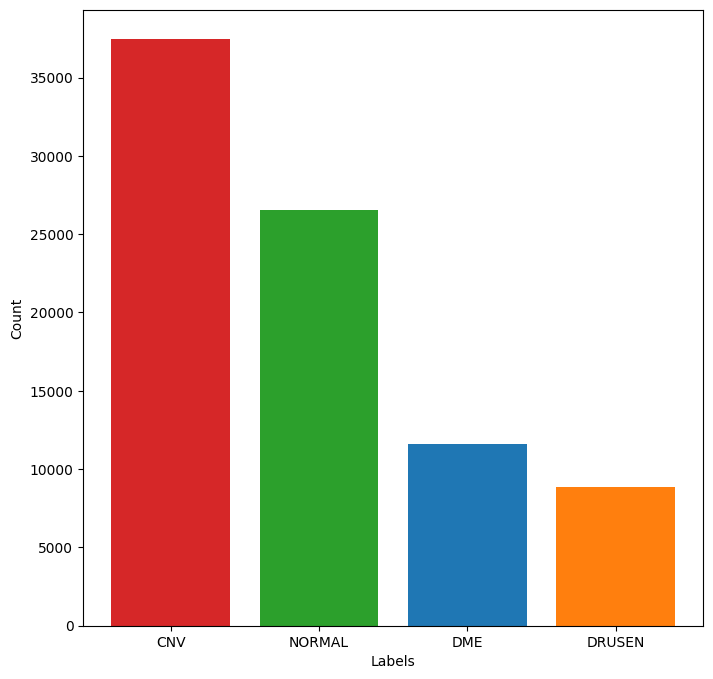

In [612]:
train_counts = df['classe'].value_counts()
labels = list(train_counts.index)
counts = list(train_counts.values)
show_labels_counts(labels, counts)

In [613]:
df['classe'].value_counts().min()

8866

In [614]:
img_width, img_height = 150, 150 
batch_size = 32
channels = 3

In [615]:

def create_data_augmented_df(df, classe):
    # Sélectionner les images correspondantes à la classe "A"
    df_class = df.loc[df['classe'] == classe]

    # Définir les transformations à effectuer
    datagen = ImageDataGenerator(
        rescale= 1./255,
        zoom_range= (0.73, 0.9),
        horizontal_flip= True,
        rotation_range= 10,
        width_shift_range= 0.10,
        fill_mode= 'constant',
        height_shift_range= 0.10,   
        brightness_range= (0.55, 0.9),
    )


    # Générer de nouvelles images augmentées pour la classe "A"
    image_generator = datagen.flow_from_dataframe(
        dataframe=df_class, 
        x_col='image',
        y_col='classe',
        target_size= (img_width, img_height), 
        color_mode= 'rgb',
        class_mode= 'categorical',
        shuffle= True,
        batch_size=32
        )
    
    new_df = pd.DataFrame({'image': image_generator.filenames, 'classe': classe}, index=df_class.index)
    
    return new_df


In [616]:
# Ajouter les nouvelles images augmentées au dataframe d'origine
train_augmented_df = pd.concat([train_df, create_data_augmented_df(train_df, 'DRUSEN')])
train_augmented_df_1 = pd.concat([train_augmented_df, create_data_augmented_df(train_df, 'DRUSEN')])
train_augmented_df_1['classe'].value_counts()

Found 8616 validated image filenames belonging to 1 classes.
Found 8616 validated image filenames belonging to 1 classes.


CNV       37205
NORMAL    26315
DRUSEN    25848
DME       11348
Name: classe, dtype: int64

In [617]:
# Ajouter les nouvelles images augmentées au dataframe d'origine
train_augmented_df_2 = pd.concat([train_augmented_df_1, create_data_augmented_df(train_df, 'DME')])
train_augmented_df_2['classe'].value_counts()

Found 11348 validated image filenames belonging to 1 classes.


CNV       37205
NORMAL    26315
DRUSEN    25848
DME       22696
Name: classe, dtype: int64

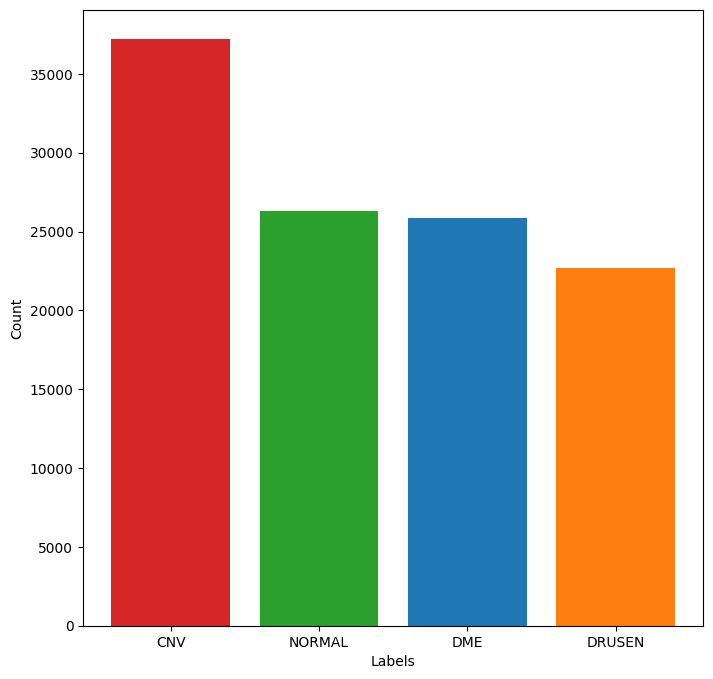

In [618]:
train_counts = train_augmented_df_2['classe'].value_counts()
counts = list(train_counts.values)
show_labels_counts(labels, counts)

In [619]:
#train_df = df[df.classe == 'CNV'].sample(frac=0.75)
cnv_to_drop = train_counts['CNV'] - train_counts['NORMAL']
cnv_to_drop_df = train_augmented_df_2[train_augmented_df_2.classe == 'CNV'].sample(n=cnv_to_drop)
train_df_1 = train_augmented_df_2.drop(cnv_to_drop_df.index, axis=0)

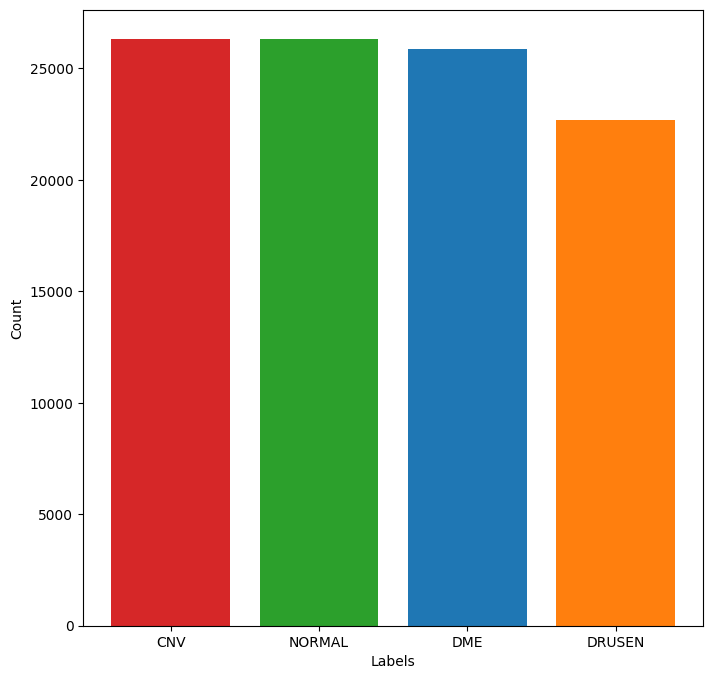

In [620]:
train_counts = train_df_1['classe'].value_counts()
counts = list(train_counts.values)
show_labels_counts(labels, counts)

In [624]:
# Sélectionner les images correspondantes à la classe "A"
df_class_A = train_df.loc[train_df['classe'].isin(['DRUSEN', 'DME'])]

# Sélectionner les images correspondantes aux autres classes
df_other_classes = train_df.loc[~train_df['classe'].isin(['DRUSEN', 'DME'])]

# Définir les transformations à effectuer pour la classe "A"
datagen_class_A = ImageDataGenerator(rotation_range=15,
                                     horizontal_flip=True,
                                     brightness_range=(0.8, 1.2))

# Générer de nouvelles images augmentées pour la classe "A"
train_generator_class_A = datagen_class_A.flow_from_dataframe(
    df_class_A, 
    x_col='image',
    y_col='classe',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Définir les transformations à effectuer pour les autres classes
datagen_other_classes = ImageDataGenerator(rescale=1./255)

# Générer des données non-augmentées pour les autres classes
train_generator_other_classes = datagen_other_classes.flow_from_dataframe(
    df_other_classes, 
    x_col='image',
    y_col='classe',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')


Found 19964 validated image filenames belonging to 2 classes.
Found 63520 validated image filenames belonging to 2 classes.


In [626]:
# Créer les objets tf.data.Dataset
def generator_class_A():
    for x, y in train_generator_class_A:
        yield (x, y)

def generator_other_classes():
    for x, y in train_generator_other_classes:
        yield (x, y)

train_dataset_class_A = tf.data.Dataset.from_generator(
    generator_class_A, 
    output_types=(tf.float32, tf.float32))

train_dataset_other_classes = tf.data.Dataset.from_generator(
    generator_other_classes, 
    output_types=(tf.float32, tf.float32))

# Fusionner les générateurs
train_generator = tf.data.experimental.sample_from_datasets(
    [train_dataset_class_A, train_dataset_other_classes])


In [543]:
# import cv2

# im_size = 150

# images = []
# labels = []

# for i in os.listdir(train_data_dir):
#     print(i)
#     data_path = train_data_dir + str(i)  
#     filenames = [i for i in os.listdir(data_path)]
    
#     for f in range(0,1000):
#         img = cv2.imread(data_path + '/' + filenames[f])
#         img = cv2.resize(img, (im_size, im_size))
#         images.append(img)
#         labels.append(i)

# images = np.array(images)
# images = images.astype('float32') / 255.0
# images.shape

# from sklearn.preprocessing import LabelEncoder , OneHotEncoder
# y = LabelEncoder().fit_transform(labels)
# y=y.reshape(-1,1)

# onehotencoder = OneHotEncoder(categories='auto')  #Converted  scalar output into vector output where the correct class will be 1 and other will be 0
# Y= onehotencoder.fit_transform(y)
# Y.shape  #(40, 2)

# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# images, Y = shuffle(images, Y, random_state=1)

# train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

# #inpect the shape of the training and testing.
# print(train_x.shape)
# print(train_y.shape)
# print(test_x.shape)
# print(test_y.shape)

In [544]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


y = LabelEncoder().fit_transform(labels)
y=y.reshape(-1,1)

onehotencoder = OneHotEncoder(categories='auto')  #Converted  scalar output into vector output where the correct class will be 1 and other will be 0
Y= onehotencoder.fit_transform(y)
Y.shape  #(40, 2)

images, Y = shuffle(train_df.image, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

ValueError: Found input variables with inconsistent numbers of samples: [101174, 4]

## Model

### Transfert learning

* VGG16 CNN architecture is used for classification.
* Pretrained on the 'ImageNet' dataset.

In [20]:
# instanciation d'un model VGG16 avec pré-entrainement imagenet
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [21]:
# creation du model avec transfert learning de vgg16 et ajout de couches de sortie
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

# Ajout de la couche de max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout de la couche d'aplatissement
model.add(Flatten())

# Ajout de la couche entièrement connectée
model.add(Dense(4096, activation='relu'))

# Ajout de la couche de dropout
model.add(Dropout(0.5))

# Ajout de la deuxième couche entièrement connectée
model.add(Dense(4096, activation='relu'))

# Ajout de la deuxième couche de dropout
model.add(Dropout(0.2))

# Ajout de la couche de sortie
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

### Baseline Model Training

In [22]:
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate= 0.001), 
    loss='categorical_crossentropy', 
    metrics= ['accuracy']
    )

In [23]:
checkpoint_filepath = model_name+'/tmp/checkpoint'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
callbacks_list = [earlystop,checkpoint]

In [39]:
# entrainement

history = model.fit(train_generator, 
                        epochs=numepochs, 
                        batch_size = batch_size,
                        validation_data=valid_generator, 
                        verbose=1,
                        callbacks = callbacks_list
                        )

Epoch 1/5


TypeError: in user code:

    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "d:\02.Pro\SIMPLON\Certification\E2\e2_retinal_oct\.venv\lib\site-packages\keras\backend.py", line 5530, in categorical_crossentropy
        target = tf.convert_to_tensor(target)

    TypeError: Failed to convert elements of SparseTensor(indices=Tensor("DeserializeSparse:0", shape=(None, 2), dtype=int64), values=Tensor("DeserializeSparse:1", shape=(None,), dtype=float32), dense_shape=Tensor("stack:0", shape=(2,), dtype=int64)) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.


### Evaluations on Test Dataset

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(test_x, test_y, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

In [ ]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig(model_name+'/img/baseline_acc_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [ ]:

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig(model_name+'/img/baseline_loss_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [ ]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig(model_name+'/img/confusion_matrix_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()


In [ ]:
print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

### Save the model

In [ ]:
model_save_h5 = model_name+"/retinal_oct_model_"+model_name+".h5"
model_save_json = model_name+"/retinal_oct_model_"+model_name+".json"
model_save_weights = model_name+"/retinal_oct_model_"+model_name+"_weights.h5"
model_save_metrics = model_name+"/retinal_oct_model_"+model_name+"_eval.json"

In [ ]:
# save model and architecture to h5 file
model.save(model_save_h5)
print("Saved h5 model to disk")

In [ ]:
#save the model architecture to JSON file
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
with open(model_save_json, 'w') as json_file:
    json_file.write(json_model)
print("Saved json model to disk")

In [ ]:
#saving the weights of the model
model.save_weights(model_save_weights)
print("Saved model weights to disk")

In [ ]:
import json
# save model metrics
json_model_eval = {}
json_model_eval["model_name"]=model_name
json_model_eval["loss"] = eval_loss
json_model_eval["accuracy"] = eval_accuracy
with open(model_save_metrics, 'w') as json_file:
    json_file.write(str(json_model_eval))
print("Saved model metrics to disk")